In [1]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d

In [2]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [3]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [33]:
Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 
                        'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos']#, 'OpticalParameters']

# File1 = "..\chroma_nEXO_OD_OD_test_210527_164627_r3326.h5"
# File1 = "..\chroma_nEXO_OD_OD_test_210528_114859_r7131.h5"
# File1 = 'chroma_nEXO_OD_OD_test_210614_150559_r5036.h5'

#Z beam straight down with one PMT in center bottom
# File1 = 'chroma_nEXO_OD_OD_test_210615_095507_r6011.h5'
# File1 = 'chroma_nEXO_OD_OD_test_210615_095856_r4567.h5'

#cherenkov source, pos [0,0,-3400], straight down
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133245_r2794.h5'
# #cherenkov source, pos [0,0,-3400], at corner [0,-1,-1]
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133535_r3926.h5'
# #cherenkov source, pos [0,0,-3400], at corner [0,-1,-1], more photons and path length 4000 mm
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_145704_r5508.h5'


#to center with WT surface set to detection: 1.0 
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_133834_r5107.h5'
#to corner with WT surface set to detection: 1.0 s
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_134205_r3434.h5'


Data1 = ReadFile(Keys1, File1)

In [34]:
print(Data1.keys())

for var in Data1.keys():
    print(var, "- number of entries:", len(Data1[var]))
    print("     ", Data1[var], '\n')

dict_keys(['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos'])
Origin - number of entries: 1
      [[    0.     0. -3100.]] 

LastHitTriangle - number of entries: 40000
      [108545 110332 108535 ... 108551 108705 108569] 

IncidentAngles - number of entries: 31114
      [90.69460542 86.48106172 87.23937665 ... 91.98124914 81.3143378
 91.44174616] 

DetectorHit - number of entries: 31114
      [[ 906.98694 -730.7615   672.03516]
 [ 906.98694 -730.7615   672.03516]
 [ 906.98694 -730.7615   672.03516]
 ...
 [ 906.98694 -730.7615   672.03516]
 [ 906.98694 -730.7615   672.03516]
 [ 906.98694 -730.7615   672.03516]] 

Flags - number of entries: 40000
      [4 4 4 ... 4 4 4] 

FinalPosition - number of entries: 40000
      [[-2117.1755  -5761.966   -5520.621  ]
 [ -413.33282 -1430.2823  -7483.5103 ]
 [-3414.592   -5091.235   -6643.4478 ]
 ...
 [-1063.456   -6052.192   -3547.6672 ]
 [-4599.4272  -4041.4563 

In [63]:
def plotLightMap(top, side, bottom, title="Light Map", logscale=False):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    binsize = (50, 50)
    
    fig.suptitle(title)
    #### top of watertank #####
    
#     if logscale:  
#         hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
#         axes[0].set_facecolor('#440154FF')
        
#     else:
#         hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap)

    empty = np.array([[10000], [10000]])
#     hist1 = axes[0].hist2d(empty[1], empty[0], bins=binsize, cmap=Colmap)
    hist1 = axes[0].hist2d([10000], [10000], bins=binsize, cmap=Colmap)
    
    

    axes[0].set_ylabel("X [mm]")
    axes[0].set_xlabel("Y [mm]")
    # axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)

    #### wall of watertank #####
    #Azimuthal position [rad]

    if logscale:  
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[1].set_facecolor('#440154FF')
        
    else:
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap)
        
    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)


    #### bottom of watertank #####
#     hist3 = axes[2].hist2d(bottom[0], bottom[1], bins=binsize, cmap=Colmap)
    if logscale:  
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[2].set_facecolor('#440154FF')
        
    else:
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap)
    axes[2].set_ylabel("X [mm]")
    axes[2].set_xlabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)

    # Find the min and max of all colors for use in setting the color scale.
    images = [hist1[-1], hist2[-1], hist3[-1]]
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    if logscale:
        if vmin <= 0 : #if log scale really we need to replace all the 0s with a very small value
            # as we're just counting counts, it just needs to be less than 1
            vmin = 0.1
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
        
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)

    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)

    cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    # cbar.set_ticklabels(['low', 'medium', 'high'])
    plt.show()

## Plotting final positions - from just a guess if it's a hit or not

In [44]:
finalPos = Data1['FinalPosition']

# topHeight = 5000
# bottomHeight = -5000
# radius = 6000

topHeight = 4000
bottomHeight = -4000
radius = 5000

#get hits on surfaces
top = []
bottom = []
side = []
all_sides = []
skipped = 0

flagTag = GetPhotonFlags(Data1['Flags'])
# print(flagTag)

saveMaxZ = 0
saveMinZ = 0


for i, pos in enumerate(finalPos):
    if flagTag['BULK_ABSORB'][i]: #don't save any photons that are absorbed in the water
#         print("skip")
        skipped +=1
    else:
        x,y,z = pos
        R = np.sqrt(x*x + y*y)
#         Az = np.arctan(y/x)
        Az = np.arctan2(y, x) #this one should really be used
    
    if saveMaxZ < z:
        saveMaxZ = z
    if saveMinZ > z:
        saveMinZ = z
        
#         print([x,y,z], [R, Az, z])
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
            top.append([x,y])
            all_sides.append([x,y,z])
        elif z <= bottomHeight:
            bottom.append([x,y])
            all_sides.append([x,y,z])
        elif R > radius:
            side.append([Az, z])
            all_sides.append([x,y,z])
            
top = np.array(top).T
bottom = np.array(bottom).T
side = np.array(side).T
all_sides = np.array(all_sides).T

In [49]:
print(saveMaxZ, saveMinZ, skipped)

print(len(top), len(bottom[0]), len(side), len(all_sides[0]))

5781.4634 -7483.5312 8555
0 7 0 7


In [ ]:
plotLightMap(top, side, bottom, logscale=True)#, title="Light Map")

In [ ]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

p = axes.scatter3D(all_sides[0], all_sides[1], all_sides[2], s=.5)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(20, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()
print(len(all_sides[0]))

## Plotting final positions - from hit flags

In [57]:
detectedPos = Data1['DetectedPos']
# finalPos[:,0]

#approximate values to only plot photons with a dimension larger than these for each of the three graphss
topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top_hits = []
bottom_hits = []
side_hits = []
all_sides_hits = []
skipped_hits = 0

PhotonFlags = [GetPhotonFlags(x) for x in Data1['Flags']]

print(PhotonFlags[0])
d = 0

for i, flagtag in enumerate(Data1['Flags']):
#     print(GetPhotonFlags(flagtag))
    if GetPhotonFlags(flagtag)['SURFACE_DETECT']: #only save those that are detected
        x,y,z = detectedPos[d]
        R = np.sqrt(x*x + y*y)
        Az = np.arctan2(y, x)
        
#         print([x,y,z], [R, Az, z])
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
            top_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif z <= bottomHeight:
            bottom_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif R > radius:
            side_hits.append([Az, z])
            all_sides_hits.append([x,y,z])
        
        d +=1
            
    else:
    #         print("skip")
        skipped +=1
            
top_hits = np.array(top_hits).T
bottom_hits = np.array(bottom_hits).T
side_hits = np.array(side_hits).T
all_sides_hits = np.array(all_sides_hits).T

{'NO_HIT': False, 'BULK_ABSORB': False, 'SURFACE_DETECT': True, 'SURFACE_ABSORB': False, 'RAYLEIGH_SCATTER': False, 'REFLECT_DIFFUSE': False, 'REFLECT_SPECULAR': False, 'SURFACE_REEMIT': False, 'SURFACE_TRANSMIT': False, 'BULK_REEMIT': False, 'MATERIAL_REFL': False, 'NAN_ABORT': False}


In [58]:
# print(len(all_sides_hits[0]))

print("Total of %i photons detected." % len(all_sides_hits[0]))

Total of 31114 photons detected.


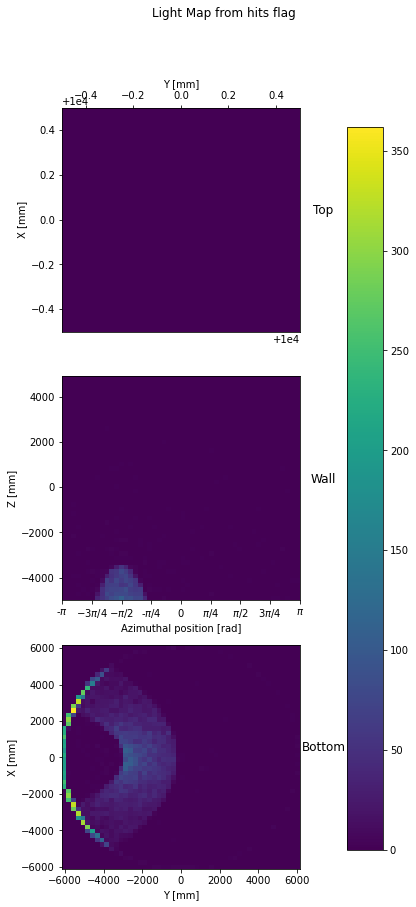

In [64]:
plotLightMap(top_hits, side_hits, bottom_hits, title="Light Map from hits flag")

## Looking at photon paths

In [40]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  

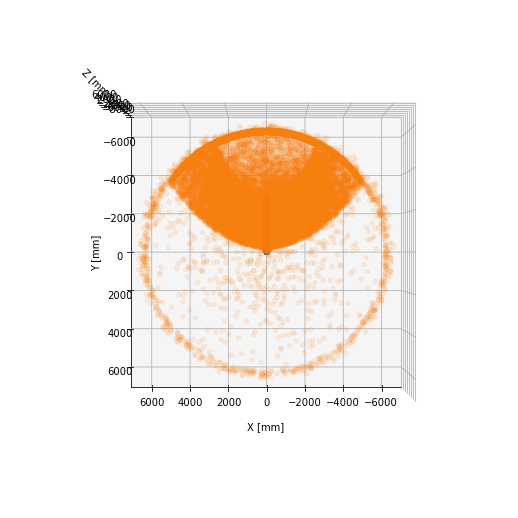

In [43]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue')
axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1)


# for i in range(len(paths)):
#     direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

#     axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
#     p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
#     print(paths[i][0][1], paths[i][1][1], paths[i][2][1])    

# axes.set_xlim3d(-100, 100)
# axes.set_ylim3d(-100, 100)
# axes.set_zlim3d(-3600, -3200)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(90, 90)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

# PMT_MetalConnection PMT_Glassware

In [ ]:
# for f in Data1['Flags']:
    
flagTag = GetPhotonFlags(Data1['Flags'])

bars = np.zeros(len(flagTag.keys()))
for i, var in enumerate(flagTag.keys()):
    bars[i] = flagTag[var].sum()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(flagTag.keys(),bars)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#plotting in more the style of the other lightmaps in chroma, but I don't like it and it doesn't currently work
def plotLightMap_M(top, side, bottom, title="Light Map", logscale=False):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    binsize = (50, 50)
    
    fig.suptitle(title)
    binNum = 1000
    #### top of watertank #####
    minX = -6000
    maxX = 6000
    minY = -6000
    maxY = 6000
    
    binX = np.linspace(minX, maxX, binNum)
    binY = np.linspace(minY, maxY, binNum)
    
    hist1, XEdges, YEdges = np.histogram2d(x=top[0], y=top[1], normed=True, bins=(binX, binY))
    X, Y = np.meshgrid(XEdges, YEdges)

    if logscale:
        hist1[hist1==0] = hist1.max()/(len(top[0])) # can't logscale 0, so replace all 0 with very small number
        im1 = axes[0].pcolormesh(X, Y, hist1.T, norm=colors.LogNorm(vmin=(hist1.T).min(),vmax=(hist1.T).max()), cmap = 'viridis')
    else:
        im1 = axes[0].pcolormesh(X, Y, hist1.T, cmap = 'viridis')
    
    
    axes[0].tick_params(axis='both', which='major', labelsize=13)

    axes[0].set_xlabel("X [mm]")
    axes[0].set_ylabel("Y [mm]")
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)
    
    axes[0].set_xlim(minX, maxX)
    axes[0].set_ylim(minY, maxY)
#     divider = make_axes_locatable(axes[0])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     cb = fig.colorbar(im, cax=cax, orientation='vertical')
#     cb.set_label(label='Number of Hits (Normalized)', fontsize=16)v

#     #### wall of watertank #####
#     #Azimuthal position [rad]
    binZ = np.linspace(-6000, 6000, binNum)
    binR = np.linspace(-np.pi, np.pi+0.1, binNum)
    
    Hist, REdges, ZEdges = np.histogram2d(x=side[0], y=side[1], normed=True, bins=(binR, binZ))
    R, Z = np.meshgrid(REdges, ZEdges)

    if logscale:
        Hist[Hist==0] = Hist.max()/(len(side[0])) # can't logscale 0, so replace all 0 with very small number
        im2 = axes[1].pcolormesh(R, Z, Hist.T, norm=colors.LogNorm(vmin=(Hist.T).min(),vmax=(Hist.T).max()), cmap = 'viridis')
    else:
        im2 = axes[1].pcolormesh(R, Z, Hist.T, cmap = 'viridis')
    
    axes[1].tick_params(axis='both', which='major', labelsize=13)

    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)

#     #### bottom of watertank #####
    Hist, XEdges, YEdges = np.histogram2d(x=bottom[0], y=bottom[1], normed=True, bins=(binX, binY))
    X, Y = np.meshgrid(XEdges, YEdges)

    if logscale:
        Hist[Hist==0] = Hist.max()/(len(top[0])) # can't logscale 0, so replace all 0 with very small number
        im3 = axes[2].pcolormesh(X, Y, Hist.T, norm=colors.LogNorm(vmin=(Hist.T).min(),vmax=(Hist.T).max()), cmap = 'viridis')
    else:
        im3 = axes[2].pcolormesh(X, Y, Hist.T, cmap = 'viridis')
    
    
    axes[2].tick_params(axis='both', which='major', labelsize=13)
    axes[2].set_xlabel("X [mm]")
    axes[2].set_ylabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)
    
    axes[2].set_xlim(minX, maxX)
    axes[2].set_ylim(minY, maxY)
  

    #Find the min and max of all colors for use in setting the color scale.
    images = [im1, im2, im3]
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    if logscale:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)

    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)
    
    cbar = fig.colorbar(im, ax=axes, shrink=0.95, pad=.14)
    plt.show()


Text(1.1, 0.5, 'Top')

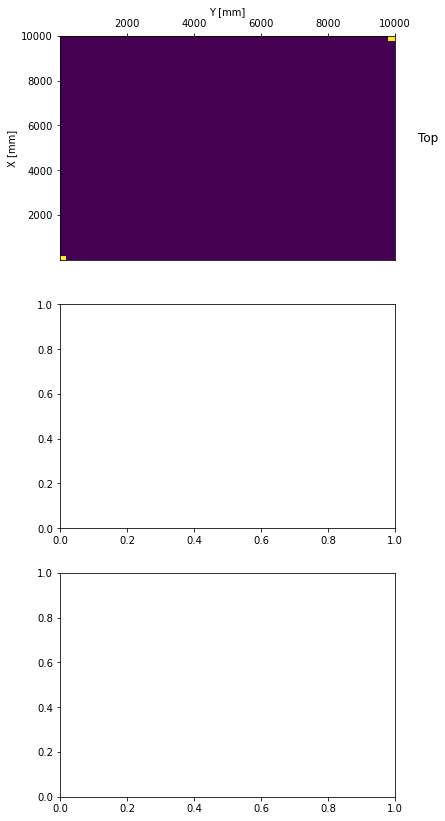

In [32]:
logscale = True

top = []

fig, axes = plt.subplots(3, 1, figsize=(6,14))

Colmap=plt.get_cmap('viridis')
binsize = (50, 50)

#### top of watertank #####
if len(top) == 0:
    ist1 = axes[0].hist2d([10000, 1], [10000, 1], bins=binsize, cmap=Colmap)
#     axes[0].set_facecolor('#440154FF')
elif logscale:  
    hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
    axes[0].set_facecolor('#440154FF')

else:
    hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap)


axes[0].set_ylabel("X [mm]")
axes[0].set_xlabel("Y [mm]")
# axes[0].tick_params(labelbottom=False,labeltop=True)
axes[0].xaxis.set_ticks_position('top') 
axes[0].xaxis.set_label_position('top')
axes[0].set_title('Top', x =1.1, y=0.5,)